# Instituto Tecnológico de Costa Rica (ITCR)
# Ciencia de Datos

## Manejo de datos faltantes (ejemplo)

-Profesora: María Auxiliadora Mora
        

### Conjunto de datos a utilizar en el ejemplo

Título: [Pima Indians Diabetes Database](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names)

Descripción: Conjunto de datos utilizado para clasificación pacientes femeninas con/sin diabetes utilizando los atributos disponibles en la base de datos. La variable diagnóstica de valor binario investigada es si la paciente muestra signos de diabetes según los criterios de la Organización Mundial de la Salud (es decir, si la glucosa plasmática 2 horas después de la carga fue al menos 200 mg/dl en cualquier examen). La población estudiada vive cerca de Phoenix, Arizona, Estados Unidos.

Fuente: National Institute of Diabetes and Digestive and Kidney Diseases

Datos:
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)
   
Disponibles en: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database   

In [1]:
# Libraries
from pandas import read_csv
from numpy import nan
from numpy import isnan

# missing values imputation
from sklearn.impute import SimpleImputer

# evaluate results
from numpy import mean
from numpy import std
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot


In [2]:
# Load the Pima Indians Diabete dataset
pima_dataset = read_csv('../../Data/Pima_Indians_diabetes.csv')
# summarize the dataset
print(pima_dataset.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

Los **valores faltantes** se pueden detactar verificando entradas fuera de rango, por ejemplo:
- números negativos en un campo numérico que normalmente solo es positivo (ej. la edad), 
- un 0 en un campo numérico que normalmente nunca puede ser 0 (ej. la masa corporal) o 
- valores nulos.

En el ejemplo específicamente, podemos notar que las columnas Glucose, BloodPressure, SkinThickness, Insulin, y el BMI tiene valor mínimo en 0. En el caso de columnas como Pregnancies un valor de cero es posible. 

In [3]:
print(pima_dataset.head(10))
print(pima_dataset.shape)

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   
5            5      116             74              0        0  25.6   
6            3       78             50             32       88  31.0   
7           10      115              0              0        0  35.3   
8            2      197             70             45      543  30.5   
9            8      125             96              0        0   0.0   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   2

In [4]:
# count the number of 0 values for each column
def count_ceros (dataset, columns):
    num_cero_values = (dataset[columns] == 0).sum()
    return num_cero_values

num_cero_values = count_ceros (pima_dataset,['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'])

# Display the results
print("===== Columnas con ceros =====")
print(num_cero_values)

===== Columnas con ceros =====
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


In [7]:
# Due to library request, first we have to replace '0' values with 'nan'
pima_dataset[['Glucose', 'BloodPressure',
              'SkinThickness', 'Insulin', 
              'BMI']]                    = pima_dataset[['Glucose', 'BloodPressure', 
                                                         'SkinThickness', 'Insulin', 
                                                         'BMI']].replace(0, nan)

# print the first 20 rows of data
print(pima_dataset.head(20))

    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0             6    148.0           72.0           35.0      NaN  33.6   
1             1     85.0           66.0           29.0      NaN  26.6   
2             8    183.0           64.0            NaN      NaN  23.3   
3             1     89.0           66.0           23.0     94.0  28.1   
4             0    137.0           40.0           35.0    168.0  43.1   
5             5    116.0           74.0            NaN      NaN  25.6   
6             3     78.0           50.0           32.0     88.0  31.0   
7            10    115.0            NaN            NaN      NaN  35.3   
8             2    197.0           70.0           45.0    543.0  30.5   
9             8    125.0           96.0            NaN      NaN   NaN   
10            4    110.0           92.0            NaN      NaN  37.6   
11           10    168.0           74.0            NaN      NaN  38.0   
12           10    139.0           80.0            

In [9]:
# count the number of 0 values for each column, there should be no zeros.

num_cero_values = count_ceros (pima_dataset,['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'])

# Display the results
print("===== Columnas con ceros =====")
print(num_cero_values)

===== Columnas con ceros =====
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64


In [10]:
# Records per class

pima_dataset.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

## Opciones de trabajo con valores faltantes

  1. Remover las filas con valores faltantes, con el inconveniente que se pierden registros.
  2. Utilizar mecanismos para limpiar esos registros: por ejemplo el **mecanismo de imputación**. El mecanismo de imputación utiliza un modelo o un algoritmo para proporcionar una predicción de los valores faltantes (Goodfellow et al.,2016)  


**1. Remover las filas con valores nan**

In [11]:
# remove rows with nan values.
print("Contenido original", pima_dataset.shape)

# inplace: whether to modify the DataFrame rather than creating a new one.
pima_dataset.dropna(inplace=True)

print("Contenido luego de remover los valores nan", pima_dataset.shape)


Contenido original (768, 9)
Contenido luego de remover los valores nan (392, 9)


**2. Imputación de valores faltantes**

La imputación puede realizar se muchas formas:
- La **media, mediana o la moda de una columna**. Una variante de este enfoque es utilizar la salida de un algoritmo de clustering para calcular la media, mediana o moda tomando en cuenta el grupo al que pertenece la muestra.
- Un **valor de otro registro** seleccionado aleatoriamente.
- Un valor **estimado por un modelo predictivo** (puede ser una red neuronal) u otro algoritmo.
- Un valor **constante**.

Nota: algunos algoritmos funcionan bien con valores faltantes, por ejemplo Naive Bayes.

Recordemos que: 
- La media corresponde a sumar todas las entradas del valor observado y dividir ese total entre el número de muestras. 
- La mediana es el valor que divide la secuencia ordenada de observaciones en dos partes iguales. Aplica para atributos ordinales. 
- La moda es el valor más frecuente.

In [12]:
# fill missing values with mean column values
pima_dataset.fillna(pima_dataset.mean(), inplace=True)
# count the number of NaN values in each column
print(pima_dataset.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


**Scikit-Learn** implementa la clase  [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) para trabajar fácilmente los valores faltantes utilizando la media, la mediana o la moda.

El parámetro strategy (default='mean') define la estratégia de imputación. Las estrategias pueden ser las siguientes (scikit-learn v1.2.1):

- “mean”, se reemplazan los valores faltantes usando la media a lo largo de cada columna. Solo se puede utilizar con datos numéricos.

- “median”, idem usando la mediana.

- “most_frequent”, idem usando la moda. Se puede utilizar con atributos numéricos o categóricos. Si hay más de un  valor que cumple, se utiliza el más pequeño.

- “constant”, se reemplazan los valores faltantes con un valor constante a lo largo de cada columna. Se puede utilizar con atributos numéricos o categóricos.


In [13]:
# retrieve the numpy array
pima_values = pima_dataset.values
# define the imputer
simple_imputer = SimpleImputer(missing_values=nan, strategy='mean')
# transform the dataset
transformed_values = simple_imputer.fit_transform(pima_values)
# count the number of NaN values in each column
print('Valores faltantes: %d' % isnan(transformed_values).sum())

Valores faltantes: 0


In [8]:
print(transformed_values)

[[  6.    148.     72.    ...   0.627  50.      1.   ]
 [  1.     85.     66.    ...   0.351  31.      0.   ]
 [  8.    183.     64.    ...   0.672  32.      1.   ]
 ...
 [  5.    121.     72.    ...   0.245  30.      0.   ]
 [  1.    126.     60.    ...   0.349  47.      1.   ]
 [  1.     93.     70.    ...   0.315  23.      0.   ]]


## Imputación y evaluación de modelos 

Ejemplo completo a manera de prueba utilizando el algoritmo Random Forest.

Etapas:
1. Dividir los datos en datos de entrenamiento y pruebas
2. Pruebas de imputación.
3. Evaluación de los resultados con validación cruzada.


Es una buena práctica evaluar los modelos de aprendizaje automático en un conjunto de datos mediante la **validación cruzada (k-fold cross-validation)**. La **validación cruzada** es un procedimiento de remuestreo utilizado para evaluar modelos de aprendizaje automático en una muestra de datos limitada.

El **procedimiento general es el siguiente**:

- Mezclar aleatoriamente el conjunto de datos.
- Dividir el conjunto de datos en k grupos.
- Para cada grupo:
    - Tomar el grupo como un conjunto de datos de prueba.
    - Tomar los grupos restantes como un conjunto de datos de entrenamiento
    - Ajustar un modelo en el conjunto de entrenamiento y evaluarlo en el conjunto de prueba
    - Conservar la puntuación de evaluación y descartar el modelo
- Visualice el rendimiento del modelo usando los puntajes obtenidos.

Aplicar validación cruzada **estratificada** significa que se divide el conjunto de datos de tal manera que conserva aproximadamente la misma distribución de clases (es decir, el mismo porcentaje de muestras de cada clase) en cada subconjunto/pliegue que en el conjunto de datos original.

Para aplicar correctamente la imputación de datos faltantes con métodos estadísticos, se requiere que las estadísticas sean calculadas para cada columna **solo en el conjunto de datos de entrenamiento y luego se apliquen a los conjuntos de entrenamiento** y prueba para cada grupo del k-fold (Brownlee, 2020).

In [15]:
# Pipeline example using RandomForestClassifier and SimpleImputer 

# retrieve the numpy array
data = pima_dataset.values

# split data in features and target
# Target (column 8) = Outcome 
ix = [i for i in range(data.shape[1]) if i != 8]
X, y = data[:, ix], data[:, 8]

# define the model pipeline
model = RandomForestClassifier()
imputer = SimpleImputer(strategy='mean')
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])

# define the model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


Mean Accuracy: 0.781 (0.052)


In [10]:
# Compare results of different statistical strategies of 
# the SimpleImputer and the RandomForestClassifier

# retrieve the numpy array
data = pima_dataset.values

# split data in features and target
# Target (column 8) = Outcome 
ix = [i for i in range(data.shape[1]) if i != 8]
X, y = data[:, ix], data[:, 8]

# evaluate each strategy on the dataset
results = list()
strategies = ['mean', 'median', 'most_frequent', 'constant']
for s in strategies:

    # create the modeling pipeline
    pipeline = Pipeline(steps=[('i', SimpleImputer(strategy=s)), ('m', RandomForestClassifier())])
    
    # evaluate the model (30 results)
    # cv = the cross-validation splitting strategy. 
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

    # store results
    results.append(scores)
    print('Desempeño (media y desviación estándar) de: %s %.3f (%.3f)' % (s, mean(scores), std(scores)))

# plot model performance for comparison
print("Cantidad de estrategias:", len(results))
print("Cantidad de evaluaciones por estrategia:", len(results[1]))



Desempeño (media y desviación estándar) de: mean 0.761 (0.044)
Desempeño (media y desviación estándar) de: median 0.757 (0.053)
Desempeño (media y desviación estándar) de: most_frequent 0.762 (0.045)
Desempeño (media y desviación estándar) de: constant 0.753 (0.047)
Cantidad de estrategias: 4
Cantidad de evaluaciones por estrategia: 30


### Diagrama de cajas o diagrama de caja y bigotes (box plot)

Un diagrama de caja es una forma de visualización estandarizada para presentar una serie de datos numéricos a través de sus cuartiles. De esta manera, se muestran a simple vista la mediana, los cuartiles de los datos y sus valores atípicos. 

Ejemplos en https://es.wikipedia.org/wiki/Diagrama_de_caja

https://www.estadisticaparatodos.es/taller/graficas/cajas.html

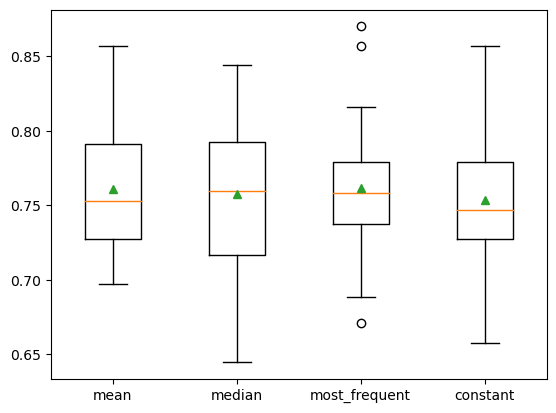

In [11]:
title = "Diagrama de caja y bigotes de las estrategias de imputación estadística aplicadas a los datos de diabetes"
pyplot.boxplot(results, labels=strategies, showmeans=True)
pyplot.show()

Los promedios del accuracy de las cuatro estategias son muy parecidos. El diagrama de caja y bigotes(boxplots o box and whiskers) muestra la distribución de puntajes de precisión para cada una de las estrategias (ie. mínimo, primer cuartil, mediana y 3er cuartil y máximo). El rango intercuartílico (longitud de la caja) indica la dispersión del 50% medio de los resultados. 


Nota: Debido a la condición estocástica del ejemplo los resultados pueden variar.  

## Referencias

Brownlee, J. (2017). How to Handle Missing Data with Python. https://machinelearningmastery.com/handle-missing-data-python/

Goodfellow, I., Bengio, Y., & Courville, A. Deep Learning (2016). Recuperado de https://www.deeplearningbook.org/

scikit-learn v1.2.1. sklearn.impute.SimpleImputer. Recuperado de https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

Brownlee, J. (2020). Statistical Imputation for Missing Values in Machine Learning. Recuperado de https://machinelearningmastery.com/statistical-imputation-for-missing-values-in-machine-learning/